Выбрано изображение: clean_image_1_downsampled_max.png


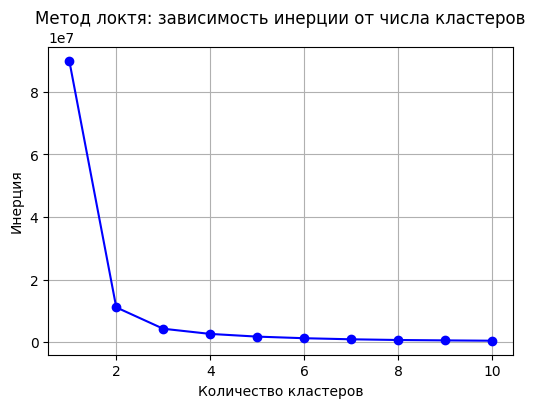

Силуэтный коэффициент: 0.79
Индекс Калинского-Харабаша: 9403.59


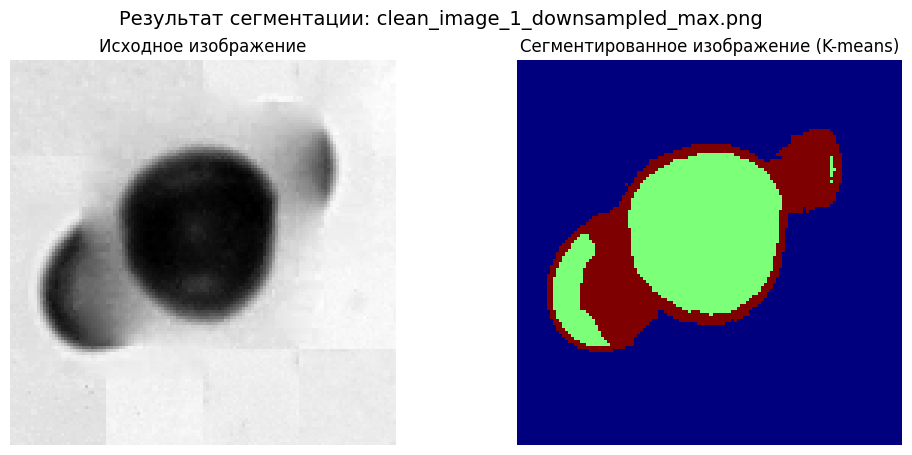

Признаки Тамура: Контраст=74.06, Крупность=114.97, Направленность=0.02
Количество связных регионов: 5


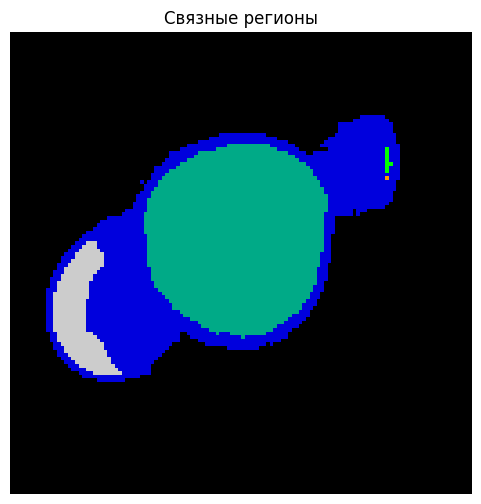

In [4]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from skimage import measure
from skimage.measure import regionprops

class ImageProcessor:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.image = None
        self.filename = None
        self.segmented = None
        self.optimal_k = None
        
    def load_random_image(self):
        files = [f for f in os.listdir(self.folder_path) if f.endswith(('.png', '.jpg', '.bmp'))]
        self.filename = random.choice(files)
        img_path = os.path.join(self.folder_path, self.filename)
        self.image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        print(f"Выбрано изображение: {self.filename}")

    def plot_elbow_method(self, max_clusters=10):
        pixels = self.image.reshape(-1, 1)
        inertia_values = []
        cluster_range = range(1, max_clusters + 1)

        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(pixels)
            inertia_values.append(kmeans.inertia_)

        plt.figure(figsize=(6, 4))
        plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
        plt.xlabel("Количество кластеров")
        plt.ylabel("Инерция")
        plt.title("Метод локтя: зависимость инерции от числа кластеров")
        plt.grid()
        plt.show()

        self.optimal_k = 3  # Можно выбрать вручную по графику
    
    def kmeans_segmentation(self):
        pixels = self.image.reshape(-1, 1)
        kmeans = KMeans(n_clusters=self.optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(pixels)
        self.segmented = labels.reshape(self.image.shape)
    
    def evaluate_clustering(self, sample_size=1000):
        pixels = self.image.reshape(-1, 1)
        labels = self.segmented.reshape(-1)

        if len(pixels) > sample_size:
            sample_idxs = random.sample(range(len(pixels)), sample_size)
            pixels = pixels[sample_idxs]
            labels = labels[sample_idxs]

        silhouette = silhouette_score(pixels, labels)
        calinski_harabasz = calinski_harabasz_score(pixels, labels)
        print(f"Силуэтный коэффициент: {silhouette:.2f}")
        print(f"Индекс Калинского-Харабаша: {calinski_harabasz:.2f}")
    
    def visualize_segmentation(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(self.image, cmap="gray")
        plt.axis("off")
        plt.title("Исходное изображение")

        plt.subplot(1, 2, 2)
        plt.imshow(self.segmented, cmap="jet")
        plt.axis("off")
        plt.title("Сегментированное изображение (K-means)")

        plt.suptitle(f"Результат сегментации: {self.filename}", fontsize=14)
        plt.show()
    
    def tamura_features(self):
        contrast = np.std(self.image)
        diff = np.abs(self.image[:-1, :-1] - self.image[1:, 1:])
        coarseness = np.mean(diff)
        grad_x = cv2.Sobel(self.image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(self.image, cv2.CV_64F, 0, 1, ksize=3)
        directionality = np.mean(np.arctan2(grad_y, grad_x))
        print(f"Признаки Тамура: Контраст={contrast:.2f}, Крупность={coarseness:.2f}, Направленность={directionality:.2f}")
    
    def connected_regions(self):
        labeled_image = measure.label(self.segmented)
        regions = regionprops(labeled_image)
        print(f"Количество связных регионов: {len(regions)}")
        return labeled_image, regions
    
    def shape_features(self, regions):
        features = [(r.area, r.perimeter, r.eccentricity) for r in regions]
        return features
    
    def process_image(self):
        self.load_random_image()
        self.plot_elbow_method()
        self.kmeans_segmentation()
        self.evaluate_clustering()
        self.visualize_segmentation()
        self.tamura_features()
        labeled_image, regions = self.connected_regions()
        shape_feats = self.shape_features(regions)

        plt.figure(figsize=(6, 6))
        plt.imshow(labeled_image, cmap="nipy_spectral")
        plt.axis("off")
        plt.title("Связные регионы")
        plt.show()

# Запуск
processor = ImageProcessor("generated_images")
processor.process_image()
